<a href="https://colab.research.google.com/github/possakorn/UoA_DL_2023_3_PK/blob/main/Assignment02_v2.0.3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assessment 2: CNNs for image classification

## Setup: import lib

In [ ]:
## section: Data manioulation
import pandas as pd
import numpy as np
## visualization
import plotly
import matplotlib.pyplot as plt
import seaborn as sns

## section: neural network
import torch
## pytorch: dataset
import torchvision
from torchvision import models
## pytorch: network and function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, OneCycleLR

from torchsummary import summary

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [191]:
# setting device on GPU if available, else CPU
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()


#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Using device: cuda

NVIDIA A100-SXM4-40GB
Memory Usage:
Allocated: 0.4 GB
Cached:    0.9 GB


## Step01: Data exploration

In [196]:
## Download from FashionMNIST
dataset = 'FashionMNIST' # change this one
torch.manual_seed(1311)
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download = True,
    transform= transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((32, 32)),  # Resize all images to 64x64
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip()
    ])
)

testing_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download = True,
    transform= transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((32, 32)),  # Resize all images to 64x64
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

In [193]:
num_class = len(training_data.classes)
num_class

10

### Exploratory Image analysis

Check Shape of images:  torch.Size([3, 32, 32]) 3
Preview Images with Label : T-shirt/top
Show of images unique labels:  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


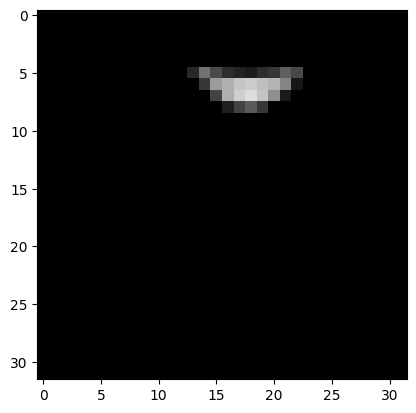

In [197]:
## check shape and labels
img, label = training_data[3]
print("Check Shape of images: ",img.shape,label)

def display_img(img,label):
  print(f"Preview Images with Label : {training_data.classes[label]}")
  plt.imshow(img.permute(1,2,0)) # for visualization following the plt need to change the shapes

#display the first image in the dataset
display_img(*training_data[2])

#Show all labels
classes = training_data.classes
print("Show of images unique labels: ",classes)

### Tranforms to Dataloader

In [198]:
batch_size = 32
## apply the dataloader
torch.manual_seed(1311)
trainloader = torch.utils.data.DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory = True
    )

testloader = torch.utils.data.DataLoader(
    testing_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory = True
    )

### Review the Batch fig and size

torch.Size([32, 3, 32, 32])


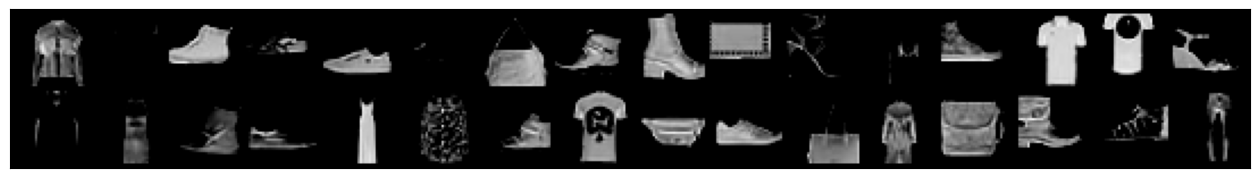

In [199]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

## show the batch fig
show_batch(trainloader)

## print the size
for batch in trainloader:
    print(batch[0].shape)  # Assuming batch[0] contains the data and batch[1] contains the labels
    break

## Base Model Functions For Image Classification

In [200]:
## adding the progress bar
import time
from tqdm import tqdm
import gc

def reset_memory():
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def train_network(model, optimizer, criterion, trainloader, testloader, num_epochs, seed=1311, num_class = num_class):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    set_seed(seed)  # Set the seed
    print('Using device:', device,"with seed: ",seed)
    print()

    class_correct = list(0. for i in range(num_class))
    class_total = list(0. for i in range(num_class))

    # create set to collect the output
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # get the input and output
    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        model.train()
        correct_train = 0
        total_train = 0
        running_loss = 0.0
        for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs} Training'):
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward feed
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == labels.data)
            total_train += labels.size(0)

        scheduler.step()

        epoch_loss = running_loss / total_train
        epoch_acc = correct_train.double() / total_train
        train_loss.append(epoch_loss)
        train_accuracy.append(int(100 * epoch_acc))

        # Validation
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(testloader, desc=f'Epoch {epoch+1}/{num_epochs} Testing'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_test += torch.sum(preds == labels.data)
                total_test += labels.size(0)



                if epoch + 1 == num_epochs:
                  # class_correct = list(0. for i in range(num_class))
                  # class_total = list(0. for i in range(num_class))
                  c = (preds == labels).squeeze()
                  for i in range(labels.size(0)):
                      label = labels[i]
                      class_correct[label] += c[i].item()
                      class_total[label] += 1



        epoch_test_loss = running_test_loss / total_test
        test_loss.append(epoch_test_loss)
        test_accuracy.append(int(100 * correct_test.double() / total_test))

        epoch_end_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {100 * epoch_acc:.2f}%, '
              f'Test Loss: {epoch_test_loss:.4f}, Test Acc: {100 * correct_test.double() / total_test:.2f}%, '
              f'Time: {epoch_end_time - epoch_start_time:.2f}s')

        if epoch + 1 == num_epochs:
          print('Accuracy for each class')
          for i in range(num_class):
            # print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
            if class_total[i] > 0:
                print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
            else:
                print('Accuracy of %5s : N/A (no training examples)' % (classes[i]))

    reset_memory()

    return train_loss, train_accuracy, test_loss, test_accuracy

## Initialize network

### network: workshop CNN

In [201]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, num_classes=num_class):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        if num_class == 10:
          self.fc1 = nn.Linear(16 * 5 * 5, 120)
          self.fc2 = nn.Linear(120, 84)
          self.fc3 = nn.Linear(84, num_class)
        else:
          self.fc1 = nn.Linear(16 * 5 * 5, 200)
          self.fc2 = nn.Linear(200, 120)
          self.fc3 = nn.Linear(120, num_class)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### network: SimpleCNN

In [202]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=num_class):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### network: Alexnet

In [203]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=num_class):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



### network: ResNet18

In [204]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes,
                               kernel_size=3, stride=stride, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes,
                               kernel_size=3,stride=1, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride,
                          bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=num_class):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

## Train the network

In [205]:
def plot_loss(train_loss, val_loss):
    """ Plot the history of losses"""
    plt.plot(train_loss, '-bx')
    plt.plot(val_loss, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show();




def plot_acc(train_acc, val_acc):
    """ Plot the accuracies in each epoch"""
    plt.plot(train_acc, '-bx')
    plt.plot(val_acc, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracies')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    plt.show();

results = []

In [206]:
# set the whole network training
import torch.optim as optim
num_epochs = 15
criterion = nn.CrossEntropyLoss()

### Train the network - net

In [207]:
# # individual configuration
# net = Net().to(device)
# model = net
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=num_epochs)

# # training model
# net_results = train_network(model,
#                             optimizer,
#                             criterion,
#                             trainloader,
#                             testloader,
#                             num_epochs
#                             )

# # plot the chart
# plot_loss(net_results[0], net_results[2])
# plot_acc(net_results[1], net_results[3])

# # save the model info
# PATH = './cifar_net.pth'
# torch.save(net.state_dict(), PATH)


### Train the network - simpleCNN

Using device: cuda with seed:  1311



Epoch 1/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 72.47it/s]


Epoch 1/15, Train Loss: 0.6639, Train Acc: 75.26%, Test Loss: 0.4542, Test Acc: 83.24%, Time: 44.00s


Epoch 2/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 73.16it/s]


Epoch 2/15, Train Loss: 0.4302, Train Acc: 83.94%, Test Loss: 0.3510, Test Acc: 87.19%, Time: 44.04s


Epoch 3/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 72.27it/s]


Epoch 3/15, Train Loss: 0.3633, Train Acc: 86.54%, Test Loss: 0.3344, Test Acc: 87.65%, Time: 43.79s


Epoch 4/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 73.59it/s]


Epoch 4/15, Train Loss: 0.3290, Train Acc: 87.74%, Test Loss: 0.2957, Test Acc: 88.85%, Time: 43.93s


Epoch 5/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 72.89it/s]


Epoch 5/15, Train Loss: 0.3030, Train Acc: 88.89%, Test Loss: 0.2975, Test Acc: 89.02%, Time: 44.29s


Epoch 6/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 72.53it/s]


Epoch 6/15, Train Loss: 0.2888, Train Acc: 89.26%, Test Loss: 0.2812, Test Acc: 89.71%, Time: 44.03s


Epoch 7/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 73.94it/s]


Epoch 7/15, Train Loss: 0.2711, Train Acc: 89.98%, Test Loss: 0.2635, Test Acc: 90.36%, Time: 44.02s


Epoch 8/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 73.08it/s]


Epoch 8/15, Train Loss: 0.2605, Train Acc: 90.35%, Test Loss: 0.2417, Test Acc: 91.22%, Time: 43.94s


Epoch 9/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 72.59it/s]


Epoch 9/15, Train Loss: 0.2512, Train Acc: 90.63%, Test Loss: 0.2777, Test Acc: 89.77%, Time: 44.21s


Epoch 10/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 74.10it/s]


Epoch 10/15, Train Loss: 0.2441, Train Acc: 91.02%, Test Loss: 0.2543, Test Acc: 90.26%, Time: 43.99s


Epoch 11/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 74.00it/s]


Epoch 11/15, Train Loss: 0.2356, Train Acc: 91.29%, Test Loss: 0.2437, Test Acc: 91.37%, Time: 44.01s


Epoch 12/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 73.65it/s]


Epoch 12/15, Train Loss: 0.2277, Train Acc: 91.67%, Test Loss: 0.2263, Test Acc: 92.02%, Time: 43.83s


Epoch 13/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 73.11it/s]


Epoch 13/15, Train Loss: 0.2222, Train Acc: 91.73%, Test Loss: 0.2238, Test Acc: 91.96%, Time: 44.09s


Epoch 14/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 73.42it/s]


Epoch 14/15, Train Loss: 0.2146, Train Acc: 91.98%, Test Loss: 0.2312, Test Acc: 91.57%, Time: 44.12s


Epoch 15/15 Testing: 100%|██████████| 313/313 [00:05<00:00, 61.86it/s]


Epoch 15/15, Train Loss: 0.2099, Train Acc: 92.28%, Test Loss: 0.2200, Test Acc: 92.20%, Time: 44.95s
Accuracy for each class
Accuracy of T-shirt/top : 86 %
Accuracy of Trouser : 98 %
Accuracy of Pullover : 86 %
Accuracy of Dress : 93 %
Accuracy of  Coat : 91 %
Accuracy of Sandal : 98 %
Accuracy of Shirt : 76 %
Accuracy of Sneaker : 95 %
Accuracy of   Bag : 99 %
Accuracy of Ankle boot : 96 %


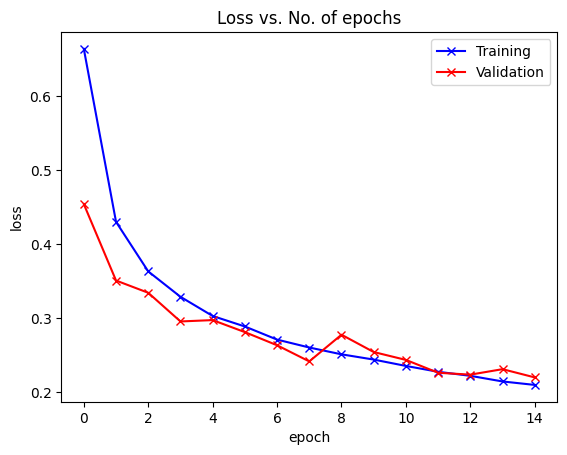

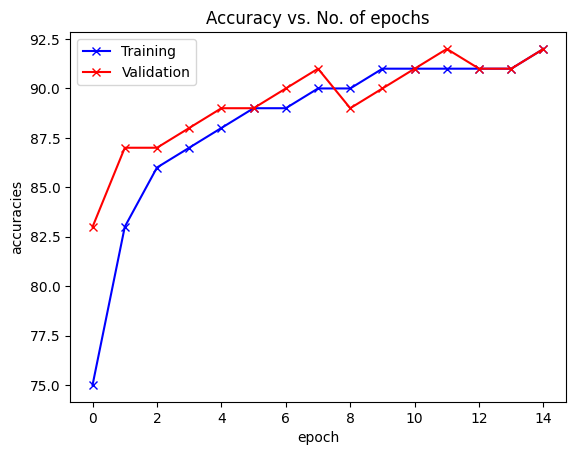

./FashionMNIST_simplecnn.pth


In [208]:
# individual configuration
simplecnn = SimpleCNN().to(device)
model_name = "simplecnn"
model = simplecnn
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=num_epochs)

# training model
simplecnn_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(simplecnn_results[0], simplecnn_results[2])
plot_acc(simplecnn_results[1], simplecnn_results[3])

# save the model info
PATH = f'./{dataset}_{str(model_name)}.pth'
print(PATH)
torch.save(simplecnn.state_dict(), PATH)

### Train the network - Alexnet

Using device: cuda with seed:  1311



Epoch 1/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 70.39it/s]


Epoch 1/15, Train Loss: 0.7335, Train Acc: 72.00%, Test Loss: 0.4626, Test Acc: 82.05%, Time: 52.21s


Epoch 2/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 71.01it/s]


Epoch 2/15, Train Loss: 0.4552, Train Acc: 83.15%, Test Loss: 0.3545, Test Acc: 87.24%, Time: 52.28s


Epoch 3/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 70.34it/s]


Epoch 3/15, Train Loss: 0.3812, Train Acc: 85.97%, Test Loss: 0.3466, Test Acc: 87.39%, Time: 52.28s


Epoch 4/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 71.04it/s]


Epoch 4/15, Train Loss: 0.3457, Train Acc: 87.45%, Test Loss: 0.2937, Test Acc: 88.90%, Time: 52.56s


Epoch 5/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 69.85it/s]


Epoch 5/15, Train Loss: 0.3192, Train Acc: 88.36%, Test Loss: 0.3115, Test Acc: 88.39%, Time: 53.20s


Epoch 6/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 70.45it/s]


Epoch 6/15, Train Loss: 0.3098, Train Acc: 88.87%, Test Loss: 0.2820, Test Acc: 89.85%, Time: 53.06s


Epoch 7/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 70.53it/s]


Epoch 7/15, Train Loss: 0.2924, Train Acc: 89.36%, Test Loss: 0.2658, Test Acc: 90.39%, Time: 52.49s


Epoch 8/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 69.97it/s]


Epoch 8/15, Train Loss: 0.2829, Train Acc: 89.79%, Test Loss: 0.2433, Test Acc: 91.38%, Time: 52.19s


Epoch 9/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 70.51it/s]


Epoch 9/15, Train Loss: 0.2720, Train Acc: 90.11%, Test Loss: 0.2693, Test Acc: 90.48%, Time: 52.10s


Epoch 10/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 69.73it/s]


Epoch 10/15, Train Loss: 0.2667, Train Acc: 90.29%, Test Loss: 0.2784, Test Acc: 89.87%, Time: 52.66s


Epoch 11/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 70.83it/s]


Epoch 11/15, Train Loss: 0.2618, Train Acc: 90.47%, Test Loss: 0.2354, Test Acc: 91.39%, Time: 52.49s


Epoch 12/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 69.54it/s]


Epoch 12/15, Train Loss: 0.2543, Train Acc: 90.86%, Test Loss: 0.2375, Test Acc: 91.16%, Time: 52.32s


Epoch 13/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 70.19it/s]


Epoch 13/15, Train Loss: 0.2499, Train Acc: 90.90%, Test Loss: 0.2528, Test Acc: 91.11%, Time: 52.39s


Epoch 14/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 70.69it/s]


Epoch 14/15, Train Loss: 0.2425, Train Acc: 91.35%, Test Loss: 0.2366, Test Acc: 91.54%, Time: 52.51s


Epoch 15/15 Testing: 100%|██████████| 313/313 [00:05<00:00, 59.79it/s]


Epoch 15/15, Train Loss: 0.2405, Train Acc: 91.39%, Test Loss: 0.2406, Test Acc: 91.61%, Time: 53.24s
Accuracy for each class
Accuracy of T-shirt/top : 86 %
Accuracy of Trouser : 97 %
Accuracy of Pullover : 87 %
Accuracy of Dress : 93 %
Accuracy of  Coat : 92 %
Accuracy of Sandal : 98 %
Accuracy of Shirt : 71 %
Accuracy of Sneaker : 94 %
Accuracy of   Bag : 97 %
Accuracy of Ankle boot : 97 %


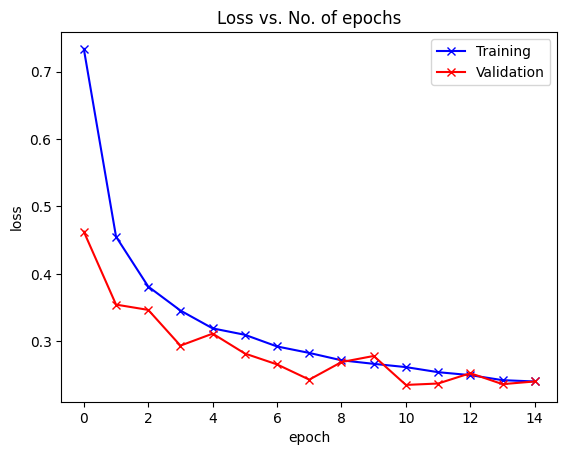

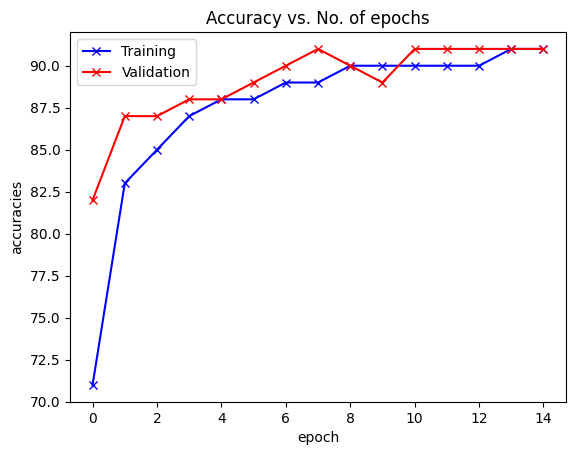

./FashionMNIST_alexnet.pth


In [209]:
# individual configuration
alexnet = AlexNet().to(device)
model_name = "alexnet"
model = alexnet
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=num_epochs)

# training model
alexnet_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(alexnet_results[0], alexnet_results[2])
plot_acc(alexnet_results[1], alexnet_results[3])

# save the model info
PATH = f'./{dataset}_{str(model_name)}.pth'
print(PATH)
torch.save(alexnet.state_dict(), PATH)

### Train the network - Resnet18

Using device: cuda with seed:  1311



Epoch 1/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 64.03it/s]


Epoch 1/15, Train Loss: 0.5489, Train Acc: 79.64%, Test Loss: 0.4191, Test Acc: 84.90%, Time: 59.17s


Epoch 2/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 63.62it/s]


Epoch 2/15, Train Loss: 0.3528, Train Acc: 87.04%, Test Loss: 0.3212, Test Acc: 88.39%, Time: 59.09s


Epoch 3/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 63.88it/s]


Epoch 3/15, Train Loss: 0.3032, Train Acc: 88.92%, Test Loss: 0.3158, Test Acc: 89.06%, Time: 59.12s


Epoch 4/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 63.93it/s]


Epoch 4/15, Train Loss: 0.2750, Train Acc: 90.02%, Test Loss: 0.2538, Test Acc: 90.78%, Time: 58.94s


Epoch 5/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 62.65it/s]


Epoch 5/15, Train Loss: 0.2552, Train Acc: 90.66%, Test Loss: 0.2609, Test Acc: 90.75%, Time: 59.01s


Epoch 6/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 63.33it/s]


Epoch 6/15, Train Loss: 0.2377, Train Acc: 91.27%, Test Loss: 0.2558, Test Acc: 91.00%, Time: 58.99s


Epoch 7/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 64.17it/s]


Epoch 7/15, Train Loss: 0.2229, Train Acc: 91.86%, Test Loss: 0.2339, Test Acc: 91.65%, Time: 58.83s


Epoch 8/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 63.26it/s]


Epoch 8/15, Train Loss: 0.2123, Train Acc: 92.29%, Test Loss: 0.2323, Test Acc: 91.79%, Time: 59.16s


Epoch 9/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 63.67it/s]


Epoch 9/15, Train Loss: 0.2020, Train Acc: 92.61%, Test Loss: 0.2392, Test Acc: 91.89%, Time: 58.89s


Epoch 10/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 64.18it/s]


Epoch 10/15, Train Loss: 0.1950, Train Acc: 92.84%, Test Loss: 0.1923, Test Acc: 93.09%, Time: 58.77s


Epoch 11/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 62.61it/s]


Epoch 11/15, Train Loss: 0.1847, Train Acc: 93.35%, Test Loss: 0.2052, Test Acc: 92.55%, Time: 58.94s


Epoch 12/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 64.00it/s]


Epoch 12/15, Train Loss: 0.1792, Train Acc: 93.44%, Test Loss: 0.1841, Test Acc: 93.51%, Time: 58.59s


Epoch 13/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 64.22it/s]


Epoch 13/15, Train Loss: 0.1701, Train Acc: 93.82%, Test Loss: 0.1938, Test Acc: 93.40%, Time: 58.75s


Epoch 14/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 64.32it/s]


Epoch 14/15, Train Loss: 0.1656, Train Acc: 94.00%, Test Loss: 0.1977, Test Acc: 92.99%, Time: 58.84s


Epoch 15/15 Testing: 100%|██████████| 313/313 [00:05<00:00, 55.44it/s]


Epoch 15/15, Train Loss: 0.1599, Train Acc: 94.21%, Test Loss: 0.1859, Test Acc: 93.31%, Time: 59.56s
Accuracy for each class
Accuracy of T-shirt/top : 87 %
Accuracy of Trouser : 99 %
Accuracy of Pullover : 92 %
Accuracy of Dress : 94 %
Accuracy of  Coat : 92 %
Accuracy of Sandal : 99 %
Accuracy of Shirt : 76 %
Accuracy of Sneaker : 96 %
Accuracy of   Bag : 98 %
Accuracy of Ankle boot : 95 %


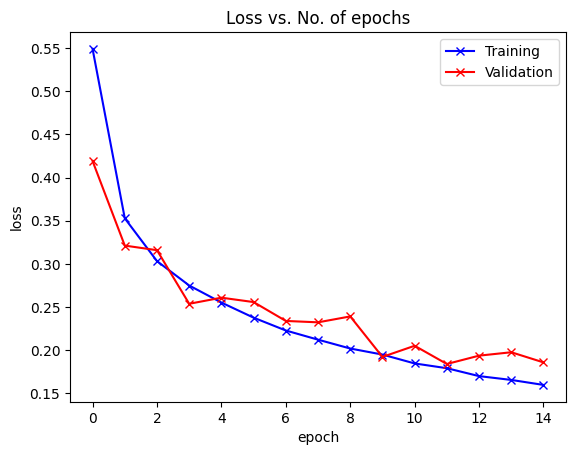

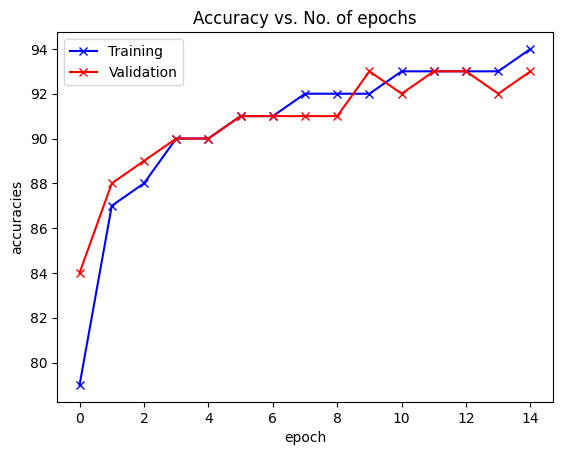

./FashionMNIST_resnet18.pth


In [210]:
# individual configuration
resnet18 = ResNet18().to(device)
model_name = "resnet18"
model = resnet18
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=8e-4)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=num_epochs)

# training model
resnet18_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(resnet18_results[0], resnet18_results[2])
plot_acc(resnet18_results[1], resnet18_results[3])

# save the model info
PATH = f'./{dataset}_{str(model_name)}.pth'
print(PATH)
torch.save(resnet18.state_dict(), PATH)

### Train the network - Resnet34

Using device: cuda with seed:  1311



Epoch 1/15 Testing: 100%|██████████| 313/313 [00:05<00:00, 56.28it/s]


Epoch 1/15, Train Loss: 0.5895, Train Acc: 78.07%, Test Loss: 0.4125, Test Acc: 84.65%, Time: 74.66s


Epoch 2/15 Testing: 100%|██████████| 313/313 [00:05<00:00, 56.07it/s]


Epoch 2/15, Train Loss: 0.3780, Train Acc: 86.07%, Test Loss: 0.3600, Test Acc: 86.83%, Time: 74.57s


Epoch 3/15 Testing: 100%|██████████| 313/313 [00:05<00:00, 56.58it/s]


Epoch 3/15, Train Loss: 0.3251, Train Acc: 88.21%, Test Loss: 0.3318, Test Acc: 88.63%, Time: 74.74s


Epoch 4/15 Testing: 100%|██████████| 313/313 [00:05<00:00, 56.77it/s]


Epoch 4/15, Train Loss: 0.2916, Train Acc: 89.55%, Test Loss: 0.2610, Test Acc: 90.38%, Time: 74.74s


Epoch 5/15 Testing: 100%|██████████| 313/313 [00:05<00:00, 55.88it/s]


Epoch 5/15, Train Loss: 0.2677, Train Acc: 90.26%, Test Loss: 0.2676, Test Acc: 90.56%, Time: 74.83s


Epoch 6/15 Testing: 100%|██████████| 313/313 [00:05<00:00, 56.27it/s]


Epoch 6/15, Train Loss: 0.2476, Train Acc: 91.03%, Test Loss: 0.2474, Test Acc: 91.18%, Time: 75.03s


Epoch 7/15 Testing: 100%|██████████| 313/313 [00:05<00:00, 56.69it/s]


Epoch 7/15, Train Loss: 0.2315, Train Acc: 91.54%, Test Loss: 0.2331, Test Acc: 91.86%, Time: 75.02s


Epoch 8/15 Testing: 100%|██████████| 313/313 [00:05<00:00, 56.64it/s]


Epoch 8/15, Train Loss: 0.2191, Train Acc: 92.06%, Test Loss: 0.2258, Test Acc: 92.00%, Time: 74.61s


Epoch 9/15 Testing: 100%|██████████| 313/313 [00:05<00:00, 56.58it/s]


Epoch 9/15, Train Loss: 0.2071, Train Acc: 92.52%, Test Loss: 0.2561, Test Acc: 91.25%, Time: 74.78s


Epoch 10/15 Testing: 100%|██████████| 313/313 [00:05<00:00, 56.30it/s]


Epoch 10/15, Train Loss: 0.1998, Train Acc: 92.77%, Test Loss: 0.1973, Test Acc: 92.83%, Time: 74.88s


Epoch 11/15 Testing: 100%|██████████| 313/313 [00:05<00:00, 56.77it/s]


Epoch 11/15, Train Loss: 0.1894, Train Acc: 93.19%, Test Loss: 0.1974, Test Acc: 92.97%, Time: 74.41s


Epoch 12/15 Testing: 100%|██████████| 313/313 [00:05<00:00, 56.29it/s]


Epoch 12/15, Train Loss: 0.1840, Train Acc: 93.23%, Test Loss: 0.1795, Test Acc: 93.56%, Time: 74.98s


Epoch 13/15 Testing: 100%|██████████| 313/313 [00:05<00:00, 56.48it/s]


Epoch 13/15, Train Loss: 0.1753, Train Acc: 93.66%, Test Loss: 0.1981, Test Acc: 92.88%, Time: 74.86s


Epoch 14/15 Testing: 100%|██████████| 313/313 [00:05<00:00, 55.79it/s]


Epoch 14/15, Train Loss: 0.1682, Train Acc: 93.90%, Test Loss: 0.1961, Test Acc: 93.16%, Time: 74.86s


Epoch 15/15 Testing: 100%|██████████| 313/313 [00:06<00:00, 49.86it/s]


Epoch 15/15, Train Loss: 0.1614, Train Acc: 94.13%, Test Loss: 0.1794, Test Acc: 93.73%, Time: 75.44s
Accuracy for each class
Accuracy of T-shirt/top : 87 %
Accuracy of Trouser : 99 %
Accuracy of Pullover : 93 %
Accuracy of Dress : 92 %
Accuracy of  Coat : 91 %
Accuracy of Sandal : 99 %
Accuracy of Shirt : 81 %
Accuracy of Sneaker : 97 %
Accuracy of   Bag : 98 %
Accuracy of Ankle boot : 96 %


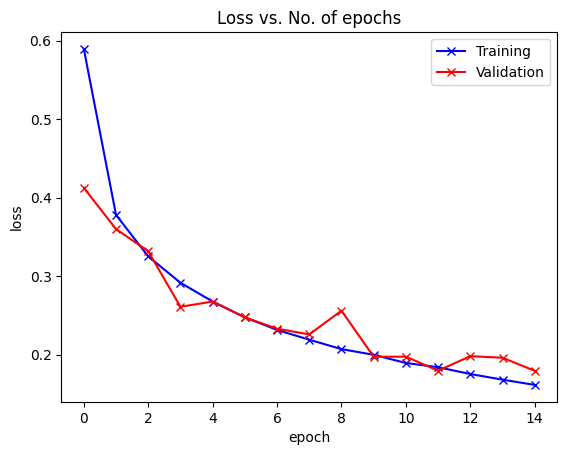

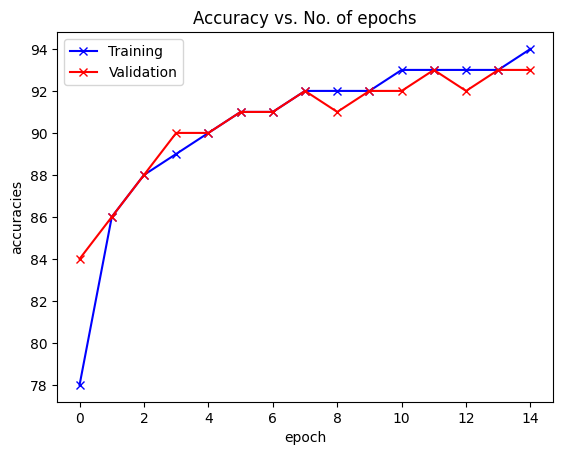

./FashionMNIST_resnet34.pth


In [211]:
# individual configuration
resnet34 = ResNet34().to(device)
model_name = "resnet34"
model = resnet34
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=8e-4)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=num_epochs)

# training model
resnet34_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(resnet34_results[0], resnet34_results[2])
plot_acc(resnet34_results[1], resnet34_results[3])

# save the model info
PATH = f'./{dataset}_{str(model_name)}.pth'
print(PATH)
torch.save(resnet34.state_dict(), PATH)

### Train the network - Resnet50

Using device: cuda with seed:  1311



Epoch 1/15 Testing: 100%|██████████| 313/313 [00:06<00:00, 49.89it/s]


Epoch 1/15, Train Loss: 0.6244, Train Acc: 77.22%, Test Loss: 0.3640, Test Acc: 87.00%, Time: 86.51s


Epoch 2/15 Testing: 100%|██████████| 313/313 [00:06<00:00, 49.41it/s]


Epoch 2/15, Train Loss: 0.3952, Train Acc: 85.69%, Test Loss: 0.4070, Test Acc: 85.65%, Time: 86.30s


Epoch 3/15 Testing: 100%|██████████| 313/313 [00:06<00:00, 50.04it/s]


Epoch 3/15, Train Loss: 0.3471, Train Acc: 87.61%, Test Loss: 0.3294, Test Acc: 88.69%, Time: 86.18s


Epoch 4/15 Testing: 100%|██████████| 313/313 [00:06<00:00, 49.71it/s]


Epoch 4/15, Train Loss: 0.3123, Train Acc: 88.79%, Test Loss: 0.2704, Test Acc: 90.22%, Time: 86.51s


Epoch 5/15 Testing: 100%|██████████| 313/313 [00:06<00:00, 49.52it/s]


Epoch 5/15, Train Loss: 0.2949, Train Acc: 89.39%, Test Loss: 0.2560, Test Acc: 90.84%, Time: 86.54s


Epoch 6/15 Testing: 100%|██████████| 313/313 [00:06<00:00, 49.85it/s]


Epoch 6/15, Train Loss: 0.2756, Train Acc: 90.07%, Test Loss: 0.2736, Test Acc: 90.16%, Time: 86.46s


Epoch 7/15 Testing: 100%|██████████| 313/313 [00:06<00:00, 49.32it/s]


Epoch 7/15, Train Loss: 0.2519, Train Acc: 90.92%, Test Loss: 0.2416, Test Acc: 91.31%, Time: 86.04s


Epoch 8/15 Testing: 100%|██████████| 313/313 [00:06<00:00, 50.13it/s]


Epoch 8/15, Train Loss: 0.2433, Train Acc: 91.27%, Test Loss: 0.2473, Test Acc: 91.53%, Time: 86.08s


Epoch 9/15 Testing: 100%|██████████| 313/313 [00:06<00:00, 49.69it/s]


Epoch 9/15, Train Loss: 0.2278, Train Acc: 91.71%, Test Loss: 0.2393, Test Acc: 91.74%, Time: 86.09s


Epoch 10/15 Testing: 100%|██████████| 313/313 [00:06<00:00, 49.72it/s]


Epoch 10/15, Train Loss: 0.2226, Train Acc: 91.98%, Test Loss: 0.2070, Test Acc: 92.45%, Time: 85.90s


Epoch 11/15 Testing: 100%|██████████| 313/313 [00:06<00:00, 49.67it/s]


Epoch 11/15, Train Loss: 0.2104, Train Acc: 92.44%, Test Loss: 0.2076, Test Acc: 92.44%, Time: 85.97s


Epoch 12/15 Testing: 100%|██████████| 313/313 [00:06<00:00, 50.06it/s]


Epoch 12/15, Train Loss: 0.2030, Train Acc: 92.63%, Test Loss: 0.2012, Test Acc: 92.89%, Time: 86.72s


Epoch 13/15 Testing: 100%|██████████| 313/313 [00:06<00:00, 49.35it/s]


Epoch 13/15, Train Loss: 0.1973, Train Acc: 92.86%, Test Loss: 0.2127, Test Acc: 92.65%, Time: 86.36s


Epoch 14/15 Testing: 100%|██████████| 313/313 [00:06<00:00, 49.69it/s]


Epoch 14/15, Train Loss: 0.1903, Train Acc: 93.10%, Test Loss: 0.2076, Test Acc: 92.50%, Time: 86.64s


Epoch 15/15 Testing: 100%|██████████| 313/313 [00:07<00:00, 44.50it/s]


Epoch 15/15, Train Loss: 0.1824, Train Acc: 93.41%, Test Loss: 0.1838, Test Acc: 93.32%, Time: 87.13s
Accuracy for each class
Accuracy of T-shirt/top : 86 %
Accuracy of Trouser : 99 %
Accuracy of Pullover : 93 %
Accuracy of Dress : 93 %
Accuracy of  Coat : 89 %
Accuracy of Sandal : 98 %
Accuracy of Shirt : 79 %
Accuracy of Sneaker : 97 %
Accuracy of   Bag : 99 %
Accuracy of Ankle boot : 96 %


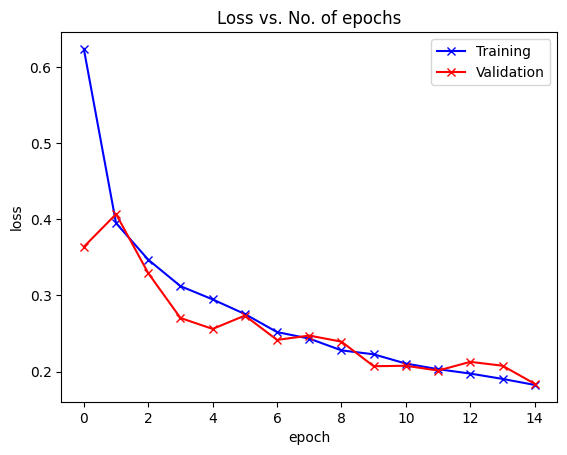

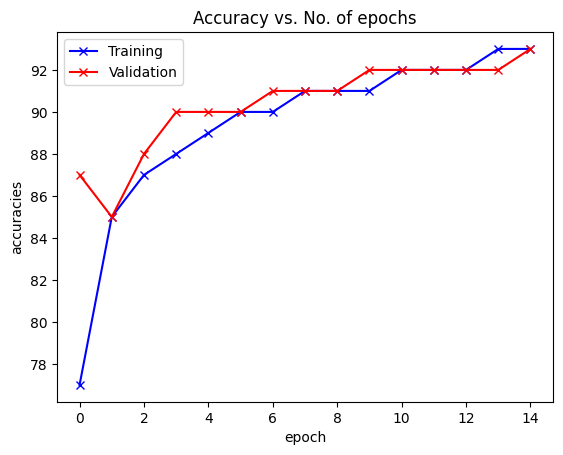

./FashionMNIST_resnet50.pth


In [212]:
# individual configuration
resnet50 = ResNet50().to(device)
model_name = "resnet50"
model = resnet50
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=8e-4)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=num_epochs)

# training model
resnet50_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(resnet50_results[0], resnet50_results[2])
plot_acc(resnet50_results[1], resnet50_results[3])

# save the model info
PATH = f'./{dataset}_{str(model_name)}.pth'
print(PATH)
torch.save(resnet50.state_dict(), PATH)

## Load the Model

In [213]:
# net = Net()
# net.load_state_dict(torch.load('./cifar_net.pth'))

simplecnn = SimpleCNN()
simplecnn.load_state_dict(torch.load(f'./{dataset}_simplecnn.pth'))

alexnet = AlexNet()
alexnet.load_state_dict(torch.load(f'./{dataset}_alexnet.pth'))

resnet18 = ResNet18()
resnet18.load_state_dict(torch.load(f'./{dataset}_resnet18.pth'))

resnet34 = ResNet34()
resnet34.load_state_dict(torch.load(f'./{dataset}_resnet34.pth'))

resnet50 = ResNet50()
resnet50.load_state_dict(torch.load(f'./{dataset}_resnet50.pth', map_location=device))

<All keys matched successfully>